In [4]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random, os, pathlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## 2D dataset
### Binary classification

In [5]:
import mylibrary.nnlib as tnn

In [6]:
#http://notmatthancock.github.io/software/dataset2d/

# data_path = "./data/noisy_moon_2d_2c.csv"
data_path = "./data/noisy_linear_2d_2c.csv"
# data_path = "./data/clean_circular_2d_2c.csv"


df = pd.read_csv(data_path)
# print(df.columns)
x1 = np.array(df['# x'], dtype=float)/200
x2 = np.array(df['y'], dtype=float)/200
y = np.array(df['label'], dtype=int)

In [7]:
def twospirals(n_points, noise=.5 , ang=720):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * ang * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

np.random.seed(1234)
# x, y = twospirals(200, ang=420)
x, y = twospirals(200, ang=400)
x, y = x/10, y.reshape(-1)
x1, x2 = x[:,0], x[:,1]

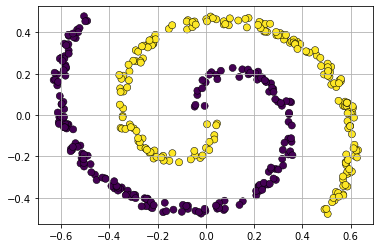

In [8]:
%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)
plt.grid()

In [9]:
xx = np.column_stack((x1, x2))
inp = torch.tensor(xx, dtype=torch.float32)
yy = torch.tensor(y, dtype=torch.float32).reshape(-1,1)

In [10]:
## for db image plotting
n = 200
x_, y_ = np.meshgrid(np.linspace(xx[:,0].min(), xx[:,0].max(), n), np.linspace(xx[:,1].min(), xx[:,1].max(), n))
xx_img = np.c_[x_.ravel(), y_.ravel()]
xx_img = torch.FloatTensor(xx_img)

v = np.linspace(0.0, 1.0, 11, endpoint=True)

In [11]:
network_seed = 147  # 147 #258 # 369

actf = nn.LeakyReLU
# actf = nn.ELU

learning_rate = 0.005

In [12]:
from classes import *

# Logistic Regression

In [13]:
torch.manual_seed(network_seed)

logNet = LogisticRegression(2)
optimizer = torch.optim.Adam(logNet.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [14]:
%matplotlib tk

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for epoch in range(10000):
    yout = logNet(inp)    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, Norm: {float(torch.norm(logNet.linear.weight.data))}')
        ax.clear()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.')
        
        yout_img = logNet(xx_img)
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape), v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:0.7226411700248718, Acc:50.0, Norm: 0.6692839860916138


Epoch: 100, Loss:0.5812911987304688, Acc:66.0, Norm: 1.5250614881515503


Epoch: 200, Loss:0.5412566065788269, Acc:67.0, Norm: 2.4023630619049072


Epoch: 300, Loss:0.5245811343193054, Acc:70.5, Norm: 3.0366668701171875


Epoch: 400, Loss:0.5177211761474609, Acc:71.0, Norm: 3.47342586517334


Epoch: 500, Loss:0.5149878263473511, Acc:71.5, Norm: 3.7657952308654785


Epoch: 600, Loss:0.513965904712677, Acc:72.0, Norm: 3.954922914505005


Epoch: 700, Loss:0.513616144657135, Acc:72.0, Norm: 4.071829319000244


Epoch: 800, Loss:0.5135083198547363, Acc:72.0, Norm: 4.140206336975098


Epoch: 900, Loss:0.5134786367416382, Acc:72.0, Norm: 4.177778720855713


Epoch: 1000, Loss:0.5134715437889099, Acc:72.0, Norm: 4.197077751159668


Epoch: 1100, Loss:0.5134699940681458, Acc:72.0, Norm: 4.206310272216797


Epoch: 1200, Loss:0.5134697556495667, Acc:72.0, Norm: 4.210409641265869


Epoch: 1300, Loss:0.5134696960449219, Acc:72.0, 

TclError: invalid command name "pyimage10"

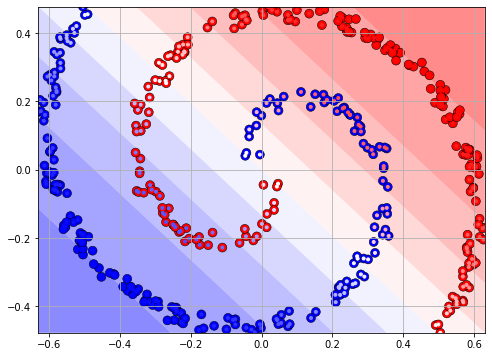

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

# Convex NN

In [16]:
torch.manual_seed(network_seed)

cvxNet = ConvexNN([2,100,100,1], actf)
sigmoid = nn.Sigmoid()

optimizer = torch.optim.Adam(cvxNet.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [17]:
%matplotlib tk

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for epoch in range(10000):
    yout = sigmoid(-cvxNet(inp))    
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}')
        ax.clear()
        yout_img = sigmoid(-cvxNet(xx_img))
        # out = (yout_img.data.numpy()>0.5).astype(int)
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")

Epoch: 0, Loss:3.090413808822632, Acc:50.0


Epoch: 100, Loss:0.5149745345115662, Acc:72.5


Epoch: 200, Loss:0.44421470165252686, Acc:74.5


Epoch: 300, Loss:0.39730557799339294, Acc:82.75


Epoch: 400, Loss:0.3826979398727417, Acc:83.0


Epoch: 500, Loss:0.37965697050094604, Acc:82.75


Epoch: 600, Loss:0.3783276677131653, Acc:83.0


Epoch: 700, Loss:0.37747156620025635, Acc:82.5


Epoch: 800, Loss:0.3769049048423767, Acc:82.75


Epoch: 900, Loss:0.37646645307540894, Acc:82.5


Epoch: 1000, Loss:0.37602829933166504, Acc:83.0


Epoch: 1100, Loss:0.3758753836154938, Acc:82.5


Epoch: 1200, Loss:0.3757450580596924, Acc:82.5


Epoch: 1300, Loss:0.3754400908946991, Acc:82.75


Epoch: 1400, Loss:0.3752180337905884, Acc:82.75


Epoch: 1500, Loss:0.3750792443752289, Acc:82.75


Epoch: 1600, Loss:0.37504908442497253, Acc:82.5


Epoch: 1700, Loss:0.3749252259731293, Acc:82.5


Epoch: 1800, Loss:0.37477341294288635, Acc:82.5


Epoch: 1900, Loss:0.3749244809150696, Acc:82.5


Epoch: 2000, Loss:0

TclError: invalid command name "pyimage20"

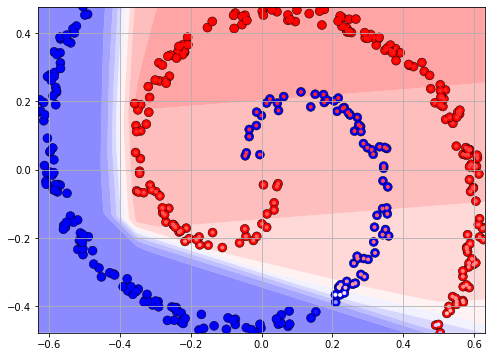

In [18]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

# Invex

In [19]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

In [20]:
class BasicInvexNet(nn.Module):
    
    def __init__(self, input_dim, net, lamda=1.):
        super().__init__()
        
        self.net = net
        self.center = nn.Parameter(torch.zeros(input_dim).unsqueeze(0))
        self.lamda = lamda
        self.X = None
        
        self.Y = None
        self.dydx_cent = None
        self.dydx = None
        
        self.gp = 0
        self.gclipper = 999
        
    def forward(self, x, hook=True):
#         self.weight_norm()
        self.X = x
        if not x.requires_grad:
            self.X = torch.autograd.Variable(x, requires_grad=True)
        
        self.Y = self.net(self.X)
        y = self.Y+0.
        if y.requires_grad and hook:
            y.register_hook(self.scale_gradient_back)
        return y
    
    def scale_gradient_back(self, grad):
        return torch.minimum(torch.maximum(grad, -self.gclipper), self.gclipper)
    
    def weight_norm(self):
        for child in get_children(self.net):
            if isinstance(child, nn.Linear):
                norm = torch.norm(child.weight.data, dim=1)
#                 print(norm)
                indx = torch.nonzero(norm>5., as_tuple=False).t()[0]
                if len(indx)==0: continue
#                 print(indx)
#                 print("Weight")
#                 print(child.weight.data[indx].shape)
                child.weight.data[indx] *= 3/(norm[indx].reshape(-1,1))
        
    def get_dydx_cent(self):
        self.dydx_cent = self.center-self.X.data
        self.dydx_cent = self.dydx_cent/torch.norm(self.dydx_cent, p=2, dim=1, keepdim=True)
        return self.dydx_cent
    
    def get_dydx(self):
        self.dydx = torch.autograd.grad(outputs=self.Y, inputs=self.X,
                                    grad_outputs=torch.ones_like(self.Y),
                                    only_inputs=True, retain_graph=True, create_graph=True)[0]
        return self.dydx
    
    def smooth_l1(self, x, beta=1):
        mask = x<beta
        y = torch.empty_like(x)
        y[mask] = 0.5*(x[mask]**2)/beta
        y[~mask] = torch.abs(x[~mask])-0.5*beta
        return y
    
    def get_gradient_penalty(self):
        m = self.dydx.shape[0]
        ## gradient is projected in the direction of center (aka. minima/maxima)
        projected_grad = torch.bmm(self.dydx.view(m, 1, -1), self.dydx_cent.view(m, -1, 1)).view(-1, 1)
        self.cond = projected_grad
        
        a=-20
#         intolerables = torch.log(torch.exp(a*(self.cond-0.1))+1)/a
#         intolerables = torch.clamp(F.softplus(self.cond-0.1, beta=-20), -1, 1)
        intolerables = F.softplus(self.cond-0.1, beta=-20)

#         dydx_norm = torch.norm(self.dydx.data, p=2, dim=1, keepdim=True)
#         self.gp = 0.5*((intolerables*5)**2).mean()*self.lamda
        
        self.gp = (self.smooth_l1(intolerables*5)).mean()*self.lamda

        return self.gp
    
    def get_gradient_clipper(self):
        with torch.no_grad():
            cond = self.cond.data
            linear_mask = cond>0.14845
            a = 20.
            gclipper = -((1.05*(cond-1))**4)+1
            gclipper = torch.log(torch.exp(a*gclipper)+1)/a
            gc2 = 3*cond-0.0844560006
            gclipper[linear_mask] = gc2[linear_mask]
            self.gclipper = gclipper
        return self.gclipper

    def MSE_loss(self, diff):
        return 0.5*(diff**2).mean()
    
    def compute_penalty_and_clipper(self):
        self.get_dydx_cent()
        self.get_dydx()
        self.get_gradient_penalty()
        self.get_gradient_clipper()
        return

In [22]:
torch.manual_seed(network_seed)
actf = nn.LeakyReLU
# actf = nn.ELU # nn.Softplus
net_lips = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
#                          nn.Sigmoid(),
                        )
sigmoid = nn.Sigmoid()
# sigmoid = lambda x: x

lcNet = BasicInvexNet(2, net_lips, lamda=1.5)

optimizer = torch.optim.Adam(lcNet.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [24]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(50000):
    yout = sigmoid(lcNet(inp))    
    lcNet.compute_penalty_and_clipper()
    loss = criterion(yout, yy) + lcNet.gp
    if float(lcNet.gp)>1:
        print("!!->", float(lcNet.gp), end=" ;; ")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(lcNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(lcNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(lcNet(xx_img))
        # out = (yout_img.data.numpy()>0.5).astype(int)
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)

Epoch: 0, Loss:1.1531463861465454, Acc:53.750003814697266, MinVal:-0.18531443178653717, gp: 0.46484535932540894


Epoch: 100, Loss:0.4402235448360443, Acc:83.0, MinVal:-0.06338421255350113, gp: 0.03154281899333


Epoch: 200, Loss:0.34053468704223633, Acc:86.0, MinVal:0.27559253573417664, gp: 1.790830026493495e-07


!!!!!!!!!!!!!!! tensor(1.8702, grad_fn=<MulBackward0>)
Epoch: 300, Loss:0.30198949575424194, Acc:89.25, MinVal:0.19219934940338135, gp: 1.1597230695770122e-05


!!!!!!!!!!!!!!! tensor(1.0544, grad_fn=<MulBackward0>)
Epoch: 400, Loss:0.2417704164981842, Acc:89.5, MinVal:0.06708865612745285, gp: 0.000663689395878464


Epoch: 500, Loss:0.17255747318267822, Acc:90.25, MinVal:0.04264378547668457, gp: 0.0006886000628583133


Epoch: 600, Loss:0.15170694887638092, Acc:91.0, MinVal:0.08678743243217468, gp: 0.000295477919280529


Epoch: 700, Loss:0.14930187165737152, Acc:91.0, MinVal:-0.07574033737182617, gp: 0.002395877381786704


Epoch: 800, Loss:0.12954992055892944, Acc:92.75, MinV

TclError: invalid command name "pyimage30"

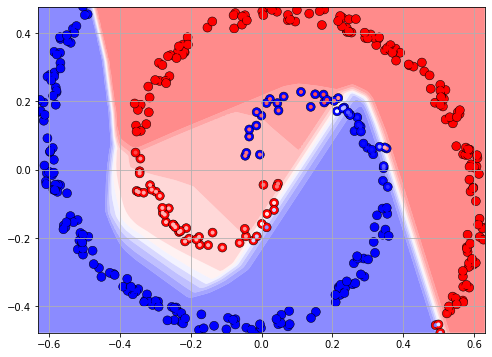

In [26]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

# Single Layer NN

In [29]:
actf = nn.LeakyReLU
# actf = nn.ELU
mlpNet = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
                         nn.Sigmoid()
                        )
optimizer = torch.optim.Adam(mlpNet.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [30]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for epoch in range(50000):
    yout = mlpNet(inp)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if epoch%100 == 0:
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}')
        yout_img = mlpNet(xx_img)
        # out = (yout_img.data.numpy()>0.5).astype(int)
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)

Epoch: 0, Loss:0.6918675899505615, Acc:65.75


Epoch: 100, Loss:0.007488364353775978, Acc:100.0


Epoch: 200, Loss:0.0005694138817489147, Acc:100.0


Epoch: 300, Loss:0.00019366940250620246, Acc:100.0


Epoch: 400, Loss:0.00010036124149337411, Acc:100.0


Epoch: 500, Loss:6.213781307451427e-05, Acc:100.0


Epoch: 600, Loss:4.2611005483195186e-05, Acc:100.0


Epoch: 700, Loss:3.1194696930469945e-05, Acc:100.0


Epoch: 800, Loss:2.3805128876119852e-05, Acc:100.0


Epoch: 900, Loss:1.8790713511407375e-05, Acc:100.0


Epoch: 1000, Loss:1.5195744708762504e-05, Acc:100.0


Epoch: 1100, Loss:1.2543197044578847e-05, Acc:100.0


Epoch: 1200, Loss:1.052082279784372e-05, Acc:100.0


Epoch: 1300, Loss:8.942610293161124e-06, Acc:100.0


Epoch: 1400, Loss:7.679864211240783e-06, Acc:100.0


Epoch: 1500, Loss:6.6620441430131905e-06, Acc:100.0


Epoch: 1600, Loss:5.825934749736916e-06, Acc:100.0


Epoch: 1700, Loss:5.129939381731674e-06, Acc:100.0


Epoch: 1800, Loss:4.546477157418849e-06, Acc:100.0




TclError: invalid command name "pyimage50"

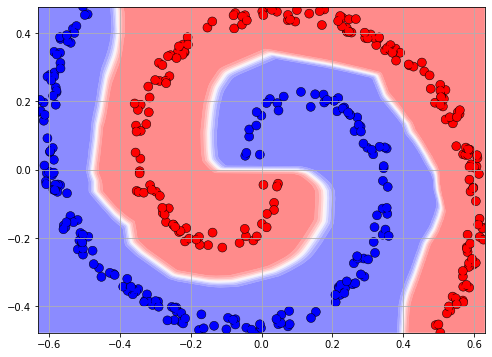

In [31]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

# Multiple Invex 

In [75]:
net_invx = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
                        )
lcNet = BasicInvexNet(2, net_invx, lamda=2)
sigmoid = nn.Sigmoid()

optimizer = torch.optim.Adam(lcNet.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [76]:
use_mixup = False
use_check = True
check_every = 2
check_size = 500
m_,s_ = (inp.max(0,True)[0] - inp.min(0,True)[0]), inp.min(0,True)[0]

In [77]:
%matplotlib tk

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for epoch in range(5000):
    
    if use_mixup:
        rand_indx = np.random.permutation(len(inp))
        rand_lambda = torch.rand(len(inp), 1)*0.1
        x_mix = rand_lambda*inp+(1-rand_lambda)*inp[rand_indx]
        y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
    else:
        x_mix = inp
        y_mix = yy
    
    yout = sigmoid(lcNet(inp))    
    lcNet.compute_penalty_and_clipper()
    loss = criterion(yout, yy) + lcNet.gp

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    
    if use_check and epoch%check_every == 0:
        rand_inp = torch.rand(check_size, 2)*m_+s_
        lcNet(rand_inp)
        lcNet.compute_penalty_and_clipper()
        lcNet.gp.backward(retain_graph=True)
        
    optimizer.step()
    if epoch%100 == 0:
        yout = sigmoid(lcNet(inp))
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(lcNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(lcNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(lcNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)

Epoch: 0, Loss:1.0666961669921875, Acc:50.0, MinVal:-0.0915469080209732, gp: 0.336761474609375
Epoch: 100, Loss:0.8447717428207397, Acc:78.75, MinVal:-0.6266577243804932, gp: 0.03775280341506004
Epoch: 200, Loss:0.3477741777896881, Acc:86.0, MinVal:0.08963736891746521, gp: 0.00021932322124484926
Epoch: 300, Loss:0.29312795400619507, Acc:86.75, MinVal:0.15720176696777344, gp: 2.4386396034969948e-05
Epoch: 400, Loss:0.19844628870487213, Acc:87.5, MinVal:0.07537674903869629, gp: 0.00023578044783789665
Epoch: 500, Loss:0.17215585708618164, Acc:88.75, MinVal:-0.04276537895202637, gp: 0.0015240136999636889
Epoch: 600, Loss:0.14858117699623108, Acc:91.0, MinVal:0.28659534454345703, gp: 7.001430901709682e-08
Epoch: 700, Loss:0.15345078706741333, Acc:91.5, MinVal:-0.40378761291503906, gp: 0.03356533870100975
Epoch: 800, Loss:0.12602324783802032, Acc:92.75, MinVal:0.15684843063354492, gp: 9.677486559667159e-06
Epoch: 900, Loss:0.11260904371738434, Acc:93.0, MinVal:-0.1305222511291504, gp: 0.0027

TclError: invalid command name "."

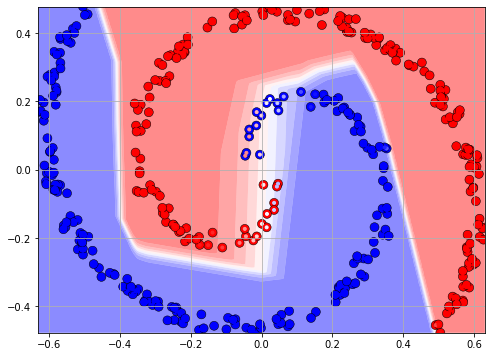

In [78]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

## Freeze initial invex func

In [79]:
net_lips = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
                        )
liNet = LipschitzInvexNet(lcNet, net_lips, lamda=2)
optimizer = torch.optim.Adam(net_lips.parameters(), lr=0.0051)

In [84]:
use_mixup = False
use_check = False
check_every = 2
check_size = 500

m_,s_ = (inp.max(0,True)[0] - inp.min(0,True)[0]), inp.min(0,True)[0]

In [86]:
%matplotlib tk

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for epoch in range(5000):
    
    if use_mixup:
        rand_indx = np.random.permutation(len(inp))
        rand_lambda = torch.rand(len(inp), 1)*0.1
        x_mix = rand_lambda*inp+(1-rand_lambda)*inp[rand_indx]
        y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
    else:
        x_mix = inp
        y_mix = yy
    
    yout = sigmoid(liNet(inp)) 
    lcNet.get_dydx()
    liNet.compute_penalty_and_clipper()
    loss = criterion(yout, yy) + liNet.gp

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    
    if use_check and epoch%check_every == 0:
        rand_inp = torch.rand(check_size, 2)*m_+s_
        liNet(rand_inp)
        lcNet.get_dydx()
        liNet.compute_penalty_and_clipper()
        liNet.gp.backward(retain_graph=True)
        
    optimizer.step()
    if epoch%100 == 0:
        yout = sigmoid(liNet(inp))
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(liNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(liNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(liNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)

Epoch: 0, Loss:0.03032856434583664, Acc:98.5, MinVal:0.7190718650817871, gp: 4.999715383746661e-05
Epoch: 100, Loss:0.03696993738412857, Acc:98.25, MinVal:1.29225492477417, gp: 4.999715383746661e-05
Epoch: 200, Loss:0.03263765573501587, Acc:99.0, MinVal:0.12991905212402344, gp: 4.999715383746661e-05
Epoch: 300, Loss:0.03239135071635246, Acc:99.0, MinVal:0.13072776794433594, gp: 4.999715383746661e-05
Epoch: 400, Loss:0.032219626009464264, Acc:99.0, MinVal:0.13043689727783203, gp: 4.999715383746661e-05
Epoch: 500, Loss:0.03205861523747444, Acc:99.0, MinVal:0.13009881973266602, gp: 4.999715383746661e-05
Epoch: 600, Loss:0.031853947788476944, Acc:99.0, MinVal:0.11643123626708984, gp: 4.999715383746661e-05
Epoch: 700, Loss:0.03168483451008797, Acc:98.75, MinVal:0.116363525390625, gp: 4.999715383746661e-05
Epoch: 800, Loss:0.03147746995091438, Acc:98.75, MinVal:0.11602020263671875, gp: 4.999715383746661e-05
Epoch: 900, Loss:0.03116440586745739, Acc:98.75, MinVal:0.11641168594360352, gp: 4.99

TclError: invalid command name "pyimage240"

tensor(98.2500)


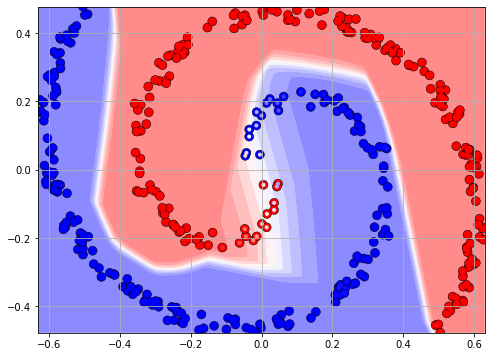

In [96]:
%matplotlib inline

yout = sigmoid(liNet(inp))
acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
out = sigmoid(liNet(xx_img)).data.numpy().astype(float)

print(acc)

fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()

### No freezing previous invex

In [90]:
net_invx = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
                        )
lcNet = BasicInvexNet(2, net_invx, lamda=2)
sigmoid = nn.Sigmoid()
criterion = nn.BCELoss()

In [91]:
net_lips = nn.Sequential(nn.Linear(2,100),
                         actf(),
                         nn.Linear(100,100),
                         actf(),
                         nn.Linear(100,1),
                        )
liNet = LipschitzInvexNet(lcNet, net_lips, lamda=2)

In [92]:
optimizer = torch.optim.Adam(liNet.parameters(), lr=0.005)

In [94]:
%matplotlib tk

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for epoch in range(5000):
    
    if use_mixup:
        rand_indx = np.random.permutation(len(inp))
        rand_lambda = torch.rand(len(inp), 1)*0.1
        x_mix = rand_lambda*inp+(1-rand_lambda)*inp[rand_indx]
        y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
    else:
        x_mix = inp
        y_mix = yy
    
    yout = sigmoid(liNet(inp)) 
    lcNet.compute_penalty_and_clipper()
    liNet.compute_penalty_and_clipper()
    
    optimizer.zero_grad()
    loss = criterion(yout, y_mix) 
    loss += liNet.gp 
    loss += lcNet.gp
    loss.backward(retain_graph=True)
    
    if use_check and epoch%check_every == 0:
        rand_inp = torch.rand(check_size, 2)*m_+s_
        liNet(rand_inp, True)
        lcNet.compute_penalty_and_clipper()
        liNet.compute_penalty_and_clipper()
        (lcNet.gp+liNet.gp).backward(retain_graph=True)
        
    optimizer.step()
    if epoch%100 == 0:
        yout = sigmoid(liNet(inp))
        acc = ((yout>0.5).type(torch.float32)==yy).type(torch.float32).mean()*100
        min_val = float(liNet.cond.min()) 
        print(f'Epoch: {epoch}, Loss:{float(loss)}, Acc:{float(acc)}, MinVal:{min_val}, gp: {float(liNet.gp)}')
        print(f'\t InvxNet; MinVal:{lcNet.cond.min()}, gp: {float(lcNet.gp)}')
        ax.clear()
        
        yout_img = sigmoid(liNet(xx_img))
        out = yout_img.data.numpy().astype(float)
        cf = ax.contourf(x_, y_, out.reshape(x_.shape),
                         v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
        ax.grid()
        ax.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
        ax.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
        
        fig.canvas.draw()
        plt.pause(0.01)

Epoch: 0, Loss:0.08577722311019897, Acc:94.5, MinVal:0.06447529792785645, gp: 0.00019258852989878505
	 InvxNet; MinVal:0.07961630821228027, gp: 0.0003004379686899483
Epoch: 100, Loss:0.07701419293880463, Acc:95.0, MinVal:0.584649920463562, gp: 5.950630071159535e-13
	 InvxNet; MinVal:0.05473661422729492, gp: 0.00028242007829248905
Epoch: 200, Loss:0.07788203656673431, Acc:94.75, MinVal:0.4658229351043701, gp: 6.89503176776185e-11
	 InvxNet; MinVal:0.06666898727416992, gp: 0.0002253969432786107
Epoch: 300, Loss:0.07866594195365906, Acc:95.75, MinVal:0.38258957862854004, gp: 5.75883651876552e-09
	 InvxNet; MinVal:0.03096151351928711, gp: 0.0008887248695828021
Epoch: 400, Loss:0.06489710509777069, Acc:96.25, MinVal:0.28264904022216797, gp: 1.0226960256431994e-07
	 InvxNet; MinVal:0.12076926231384277, gp: 7.363156328210607e-05
Epoch: 500, Loss:0.10477333515882492, Acc:93.0, MinVal:4.655803203582764, gp: 0.0
	 InvxNet; MinVal:-0.024938583374023438, gp: 0.0010460700141265988
Epoch: 600, Loss:

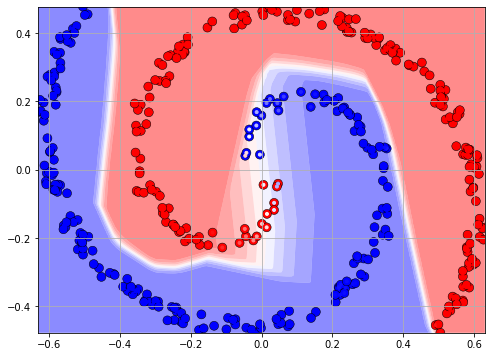

In [95]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
plt.contourf(x_, y_, out.reshape(x_.shape),
             v, alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, c=yy.data.numpy().reshape(-1), s=80, edgecolors='k', lw=0.5, cmap=matplotlib.cm.bwr)
yout = sigmoid(liNet(inp))
plt.scatter(x1, x2, c=yout.data.numpy().reshape(-1), marker='.', cmap=matplotlib.cm.bwr)
plt.grid()